# Frequentist Inference Case Study - Part B

## Learning objectives

Welcome to Part B of the Frequentist inference case study! The purpose of this case study is to help you apply the concepts associated with Frequentist inference in Python. In particular, you'll practice writing Python code to apply the following statistical concepts: 
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, including its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate a confidence interval

In the previous notebook, we used only data from a known normal distribution. **You'll now tackle real data, rather than simulated data, and answer some relevant real-world business problems using the data.**

## Hospital medical charges

Imagine that a hospital has hired you as their data scientist. An administrator is working on the hospital's business operations plan and needs you to help them answer some business questions. 

In this assignment notebook, you're going to use frequentist statistical inference on a data sample to answer the questions:
* has the hospital's revenue stream fallen below a key threshold?
* are patients with insurance really charged different amounts than those without?

Answering that last question with a frequentist approach makes some assumptions, and requires some knowledge, about the two groups.

We are going to use some data on medical charges obtained from [Kaggle](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset). 

For the purposes of this exercise, assume the observations are the result of random sampling from our single hospital. Recall that in the previous assignment, we introduced the Central Limit Theorem (CLT), and its consequence that the distributions of sample statistics approach a normal distribution as $n$ increases. The amazing thing about this is that it applies to the sampling distributions of statistics that have been calculated from even highly non-normal distributions of data! Recall, also, that hypothesis testing is very much based on making inferences about such sample statistics. You're going to rely heavily on the CLT to apply frequentist (parametric) tests to answer the questions in this notebook.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # Initialize seaborn's style
import scipy.stats as stats
from scipy.stats import norm
from numpy.random import seed
medical = pd.read_csv('insurance2.csv')

In [2]:
medical.shape

(1338, 8)

In [3]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


__Q1:__ Plot the histogram of charges and calculate the mean and standard deviation. Comment on the appropriateness of these statistics for the data.

__A:__

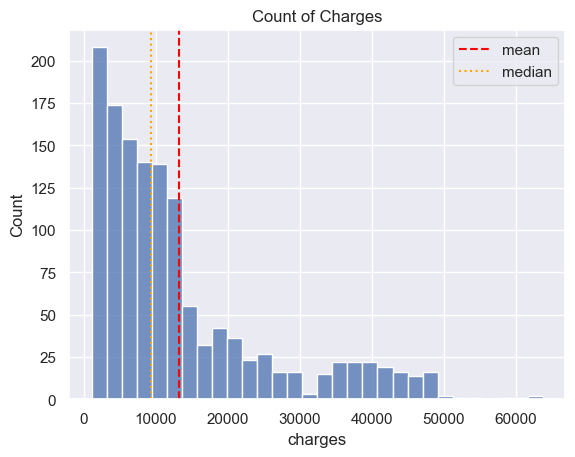

In [4]:
# Histogram
ax = sns.histplot(medical, x='charges')
ax.set_title('Count of Charges')
ax.axvline(np.mean(medical.charges), color='red', linestyle='--', label='mean')
ax.axvline(np.median(medical.charges), color='orange', linestyle=':', label='median')
ax.legend()

In [5]:
# Mean & Standard Deviation
medical.charges.describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

|__Q2:__ The administrator is concerned that the actual average charge has fallen below 12,000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed so far, to apply?

__A:__
Let's test the p-value, with NULL Hypothesis (H0) assuming that the Administrator's claim that actual charge is below 12K correct, we want to know what's the probability of observing an "extreme" mean value in current sample (ie. which is 13,270). If the p-value is < 0.05, then we consider as statistical-significance/unlikely that sample's mean can be that big (13.2K) therefore rejecting the NULL Hypothesis (H0). Otherwise, if p-value is >= 0.05, we fail to reject the Null Hypothesis (H0) that sample mean of 13.2K can be merely from a random chance. 

In [6]:
# H0: The Actual Charge is <= $12K (assuming Administrator's claim was correct)
# H1: The Actual Average Charge is > $12K

t_statistic, p_value = stats.ttest_1samp(
    medical.charges, 
    popmean=12000,
    alternative='greater' # Setting Alternative Hypothesis (H1) that population mean > 'popmean' (ie. actual charge > 12K)
)

p_value /= 2 # Dividing p-value by 2 for a one-sided T-Test

print(f"t-statistic: {t_statistic}.")
print(f"p-value (the probability of observing an 'extreme' mean value of {np.mean(medical.charges)} when assuming that population's mean is <= $12K):"
      f"{round(p_value * 100, 4)}%.")
print("Decision: REJECT the NULL Hypothesis. Actual Charge is likely > $12K.")

t-statistic: 3.8373517196585314.
p-value (the probability of observing an 'extreme' mean value of 13270.422265141257 when assuming that population's mean is <= $12K):0.0033%.
Decision: REJECT the NULL Hypothesis. Actual Charge is likely > $12K.


Below is using another method with Bootstrap using MEAN. The result also showed low probability % of drawing sample mean < $12K (which means, it's very unlikely that the average/mean charge is below $12K).

In [8]:
# Bootstrap using MEAN
n_bootstrap_samples = 10000
bootstrap_sample_size = len(medical.charges)  # Use the size of your original sample

bootstrap_means = np.empty(n_bootstrap_samples)

# Generate bootstrap samples and compute the means
for i in range(n_bootstrap_samples):
    bootstrap_sample = np.random.choice(medical.charges, size=bootstrap_sample_size, replace=True)
    bootstrap_means[i] = np.mean(bootstrap_sample)

# Compute the 95% confidence interval
ci_lower, ci_upper = np.percentile(bootstrap_means, [2.5, 97.5])

print(f"95% confidence interval for the mean: ({ci_lower}, {ci_upper})")

95% confidence interval for the mean: (12621.290558601795, 13939.956410323617)


In [10]:
# Probability that sampling distribution has mean $12K or less
probability = norm.cdf(11999, loc=np.mean(bootstrap_means), scale=np.std(bootstrap_means, ddof=1))
print(f"probability that sampling distribution has mean < $12K: {round(probability * 100, 4)}%")

probability that sampling distribution has mean < $12K: 0.0065%


[Text(0.5, 1.0, 'Count of MEAN Bootstrap'), Text(0.5, 0, 'charges')]

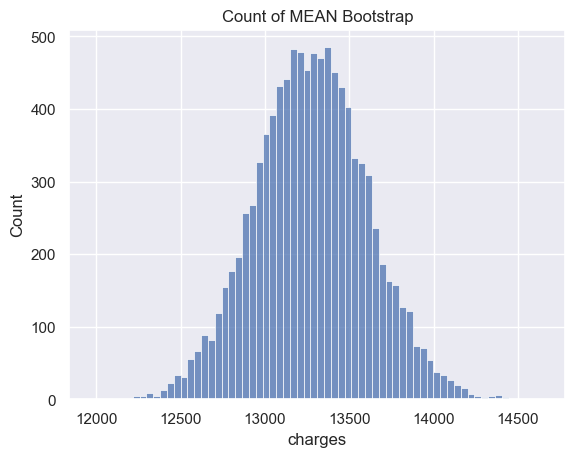

In [11]:
ax = sns.histplot(bootstrap_means)
ax.set(title='Count of MEAN Bootstrap', xlabel='charges')

However, it might be a different story if what the Administrator meant was "commonly occurring charge", which could indicate "median" instead of "mean". If that's the case, the sample Median (9,382) is actually consistent with the Administrator's claim (< 12K). Bootstrap result also showed 95% Confidence Interval of 8.8K - 9.8K). And the probability of having sample < 12K reached 100%.

In [14]:
# Bootstrap using MEDIAN
n_bootstrap_samples = 10000
bootstrap_sample_size = len(medical.charges)  # Use the size of your original sample

bootstrap_median = np.empty(n_bootstrap_samples)

# Generate bootstrap samples and compute the means
for i in range(n_bootstrap_samples):
    bootstrap_sample = np.random.choice(medical.charges, size=bootstrap_sample_size, replace=True)
    bootstrap_median[i] = np.median(bootstrap_sample)

# Compute the 95% confidence interval
ci_lower, ci_upper = np.percentile(bootstrap_median, [2.5, 97.5])

print(f"95% confidence interval for the mean: ({ci_lower}, {ci_upper})")

95% confidence interval for the mean: (8803.218540625, 9875.6804)


In [15]:
# Probability that sampling distribution has mean $12K or less
probability = norm.cdf(11999, loc=np.mean(bootstrap_median), scale=np.std(bootstrap_median, ddof=1))
print(f"probability that sampling distribution has mean < $12K: {round(probability * 100, 4)}%")

probability that sampling distribution has mean < $12K: 100.0%


[Text(0.5, 1.0, 'Count of MEDIAN Bootstrap'), Text(0.5, 0, 'charges')]

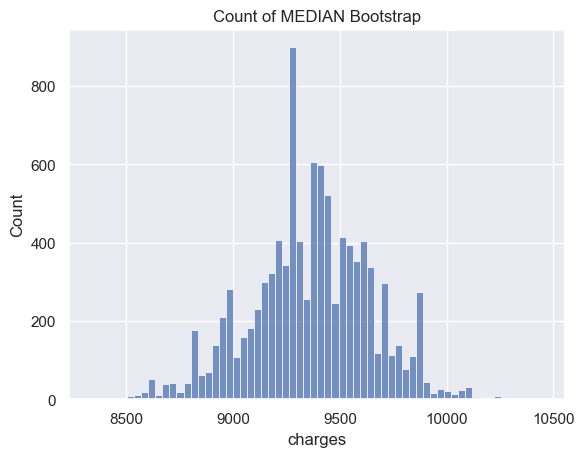

In [44]:
ax = sns.histplot(bootstrap_median)
ax.set(title='Count of MEDIAN Bootstrap', xlabel='charges')

__Q3:__ Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A ***one-sided*** or ***two-sided*** interval? (Refresh your understanding of this concept on p. 399 of the *AoS*). Calculate the critical value and the relevant 95% confidence interval for the mean, and comment on whether the administrator should be concerned.

__A:__
We'll use one-sided t-test 95% Confidence Interval, which means the lower bound will be the 0.05 quantile (instead of 0.025 for two-sided). The result of lower bound from sample's mean is 12,725 (still greater than Administrator's claim of < 12K). 

In [23]:
sample_size = len(medical.charges)
sample_mean = np.mean(medical.charges)
sample_std = np.std(medical.charges, ddof=1)  # ddof=1 to use sample standard deviation

# Calculate the standard error
standard_error = sample_std / np.sqrt(sample_size)

# Calculate the critical value from the t-distribution
    # For a one-sided test at the 95% confidence level, we look at the 5% point (0.05) of the t-distribution
critical_value = stats.t.ppf(0.05, df=sample_size-1)

# Calculate the margin of error
margin_of_error = critical_value * standard_error

# Calculate the lower bound of the 95% confidence interval
confidence_interval_lower_bound = sample_mean + margin_of_error  # We add because the critical_value is negative

print(f"95% confidence interval for the mean (lower bound): {confidence_interval_lower_bound}")

95% confidence interval for the mean (lower bound): 12725.48718381623


The administrator then wants to know whether people with insurance really are charged a different amount to those without.

__Q4:__ State the null and alternative hypothesis here. Use the _t_-test for the difference between means, where the pooled standard deviation of the two groups is given by:
\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

and the *t*-test statistic is then given by:

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

(If you need some reminding of the general definition of ***t-statistic***, check out the definition on p. 404 of *AoS*). 

What assumption about the variances of the two groups are we making here?

__A:__
- Null Hypothesis (N0): People with insurance are charged the SAME amount as those without.
- Alternative Hypothesis (H1): People with insurance are charged DIFFERENT amount as those without.

__Q5:__ Perform this hypothesis test both manually, using the above formulae, and then using the appropriate function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) (hint, you're looking for a function to perform a _t_-test on two independent samples). For the manual approach, calculate the value of the test statistic and then its probability (the p-value). Verify you get the same results from both.

__A:__ 

In [24]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In [54]:
# Separating the data into new df
charges_with_insurance_claim = medical.charges[medical.insuranceclaim == 1]
charges_without_insurance_claim = medical.charges[medical.insuranceclaim != 1]

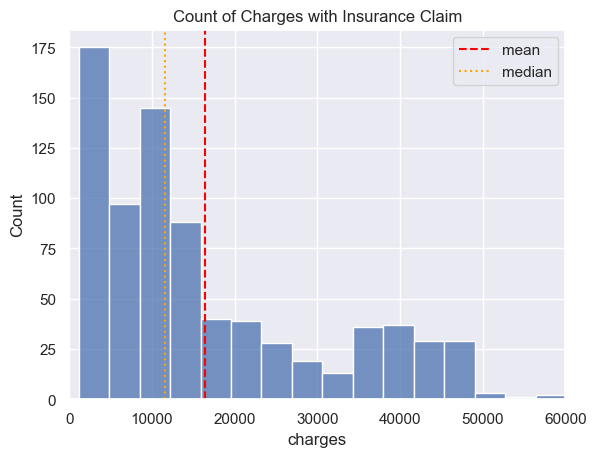

In [52]:
# Charges for Insurance Claim
# charges_with_insurance_claim.describe()
ax = sns.histplot(charges_with_insurance_claim)
ax.set(title='Count of Charges with Insurance Claim', xlabel='charges', xlim=[0, 60000])
ax.axvline(np.mean(charges_with_insurance_claim), color='red', linestyle='--', label='mean')
ax.axvline(np.median(charges_with_insurance_claim), color='orange', linestyle=':', label='median')
ax.legend()

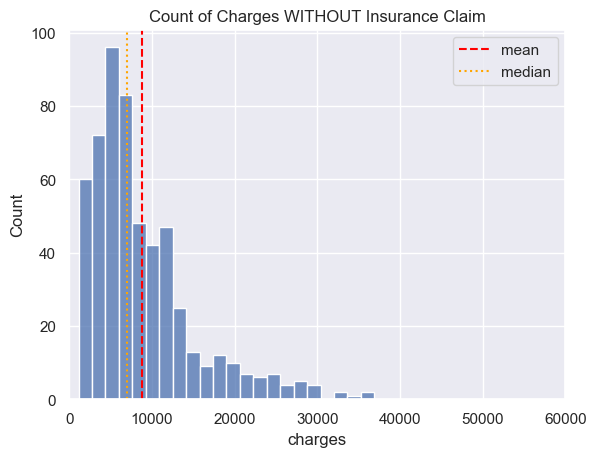

In [53]:
# Charges for Non-Insurance Claim
# charges_without_insurance_claim.describe()
# Charges for Insurance Claim
# charges_with_insurance_claim.describe()
ax = sns.histplot(charges_without_insurance_claim)
ax.set(title='Count of Charges WITHOUT Insurance Claim', xlabel='charges', xlim=[0, 60000])
ax.axvline(np.mean(charges_without_insurance_claim), color='red', linestyle='--', label='mean')
ax.axvline(np.median(charges_without_insurance_claim), color='orange', linestyle=':', label='median')
ax.legend()

In [59]:
# Comparing some stats for Charges with Insurance
charges_with_insurance_claim.describe()

count      783.000000
mean     16423.928277
std      14045.928419
min       1131.506600
25%       5733.288925
50%      11538.421000
75%      23484.788875
max      63770.428010
Name: charges, dtype: float64

In [60]:
# Comparing some stats for Charges WITHOUT Insurance
charges_without_insurance_claim.describe()

count      555.000000
mean      8821.421892
std       6446.510127
min       1121.873900
25%       4445.337575
50%       6933.242250
75%      11424.211575
max      36910.608030
Name: charges, dtype: float64

Given that the standard deviation of two samples are pretty different, we'll use the "Unequal Variance" method to compute t-statistic and degree of freedom ([reference](https://www.qualitygurus.com/two-sample-t-test/))


**t-value Unequal Variance**

$\LARGE{t = \frac{\overline{x}_1 - \overline{x}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}}$


**Degrees of Freedom (Unequal Variance)**

$\LARGE{ df = \frac{(\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2})^2}{\frac{(s_1^2/n_1)^2}{n_1 - 1} + \frac{(s_2^2/n_2)^2}{n_2 - 1}}}$

In [91]:
# Group 1 refers to "Charges with Insurance Claim"
# Group 2 refers to "Charges WITHOUT Insurance Claim"

# Calculate the sample statistics
mean1 = np.mean(charges_with_insurance_claim)
mean2 = np.mean(charges_without_insurance_claim)
sd1 = np.std(charges_with_insurance_claim, ddof=1)  # ddof=1 to use sample standard deviation
sd2 = np.std(charges_without_insurance_claim, ddof=1)  # ddof=1 to use sample standard deviation
n1 = len(charges_with_insurance_claim)
n2 = len(charges_without_insurance_claim)

# Calculate the test statistic (Unequal Variance)
t_statistic = (
    (mean1 - mean2) 
        / np.sqrt((sd1**2/n1) + (sd2**2/n2))
)

# Calculate the degrees of freedom (Unequal Variance)
df = (
    ((sd1**2/n1 + sd2**2/n2)**2) 
        / (((sd1**2 / n1)**2 / (n1-1)) + ((sd2**2 / n2)**2 / (n2-1)))
)

# Calculate the Critical Value for t-distribution, 95% Confidence Interval
critical_value = stats.t.ppf(0.975, df=df)

# Another way, to look by the p-value of observing a data as extreme as "t_statistic". And then we subtract this from 1 because we want to get the probability of getting the tail. And then multiply by 2 for two-tailed test.
p_value = 2 * (1 - stats.t.cdf(np.abs(t_statistic), df))

print("Manual Approach:")
print(f"Test Statistic: {t_statistic}")
print(f"Critical Value: {critical_value}")
print(f"Degrees of Freedom: {df}")
print(f"The p-value is < .00001 ({p_value}).")
print(f"\nTest Statistic/t-score ({t_statistic}) is greater than Critical Value ({critical_value}): REJECT NULL Hypothesis, and ACCEPT ALTERNATIVE HYPOTHESIS - People with insurance are charged DIFFERENT amount as those without.")
print(f"\nThe very small p-value also indicates strong reason to reject the NULL Hypothesis.")

Manual Approach:
Test Statistic: 13.298031957975649
Critical Value: 1.9619936369413875
Degrees of Freedom: 1169.9961514297033
The p-value is < .00001 (0.0).

Test Statistic/t-score (13.298031957975649) is greater than Critical Value (1.9619936369413875): REJECT NULL Hypothesis, and ACCEPT ALTERNATIVE HYPOTHESIS - People with insurance are charged DIFFERENT amount as those without.

The very small p-value also indicates strong reason to reject the NULL Hypothesis.


Another way using "scipy.stats.ttest_ind" method ([reference](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)).

The function will calculate the T-test for the means of two independent samples of scores.

This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.

In [93]:
scipy_ttest_two_independent_sample = stats.ttest_ind(
    a=charges_with_insurance_claim, 
    b=charges_without_insurance_claim,
    equal_var=False # Indicated earlier that the two samples had quite different standard deviation
)

In [95]:
print(f"t-value: {scipy_ttest_two_independent_sample.statistic}")
print(f"degree of freedom: {scipy_ttest_two_independent_sample.df}")
print(f"p-value: {scipy_ttest_two_independent_sample.pvalue}")

t-value: 13.298031957975649
degree of freedom: 1169.9961514297029
p-value: 1.1105103216309125e-37


The test above shows the same result as manual. In conclusion, we REJECT NULL HYPOTHESIS and accept the ALTERNATIVE HYPOTHESIS that people with insurance are charged with different (apparently more expensive) amount.

Congratulations! Hopefully you got the exact same numerical results. This shows that you correctly calculated the numbers by hand. Secondly, you used the correct function and saw that it's much easier to use. All you need to do is pass your data to it.

__Q6:__ Conceptual question: look through the documentation for statistical test functions in scipy.stats. You'll see the above _t_-test for a sample, but can you see an equivalent one for performing a *z*-test from a sample? Comment on your answer.

__A:__
The scipy.stats library does not have a built-in function for performing a z-test from a sample, unlike the t-test for which it provides the ttest_1samp and ttest_ind functions.

The main reason for this is that z-tests are rarely used in practice when analyzing data from a sample. This is because z-tests require knowledge of the population standard deviation, which is usually unknown. In contrast, t-tests only require the sample standard deviation, which can be easily calculated from the sample data.

When the population standard deviation is unknown, the sample standard deviation is used as an estimate. However, this estimate tends to be less accurate for smaller sample sizes, which leads to a different distribution (the t-distribution) being used instead of the normal distribution.

In cases where the sample size is large (usually considered as more than 30), the t-distribution approaches the normal distribution, and a t-test will give virtually the same result as a z-test. This is why the t-test is more commonly used in practice, and why scipy.stats provides built-in functions for the t-test but not the z-test.

To perform a z-test, we can use the "statsmodels" library, which provides the statsmodels.stats.weightstats.ztest function. However, only use this if we are sure that the population standard deviation is known, or if the sample size is large and we are willing to assume that the sample standard deviation is a good estimate of the population standard deviation.

## Learning outcomes

Having completed this project notebook, you now have good hands-on experience:
* using the central limit theorem to help you apply frequentist techniques to answer questions that pertain to very non-normally distributed data from the real world
* performing inference using such data to answer business questions
* forming a hypothesis and framing the null and alternative hypotheses
* testing this using a _t_-test